In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.api as sm
import warnings
from ipynb.fs.full.utils import dftest

### Volatility Modeling

Here we look to model the returns of the bitcoin price and the volatility of the price. We look to use various techniques to get an idea of volatility of the bitcoin. Also we look to test some of the questions regarding the volatility of the bitcoin.
1. Is the volatility of bitcoin dependent on the volatility of ethereum and solana?
2. Is the volatility of bitcoin high in the months of quarterly report publications.

In [2]:
# Reading the data
data = pd.read_csv("crypto_data.csv")
data.sample()

Unnamed: 0                       Date  Adj Close_BTC-USD  \
332         332  2021-11-29 00:00:00+00:00       57806.566406   

     Adj Close_ETH-USD  Adj Close_SOL-USD  Volume_BTC-USD  Volume_ETH-USD  \
332         4445.10498         204.319366     32370840356     19086475837   

     Volume_SOL-USD  
332      2110532147

In [3]:
# Extracting relevant columns
vol_cols = [i for i in data.columns if 'Volume' in i]
vol_cols.append(data.columns[0])
bitcoin_data = data.drop(vol_cols,axis=1)

In [4]:
# Taking a look at the data
bitcoin_data.sample(5)

Date  Adj Close_BTC-USD  Adj Close_ETH-USD  \
1295  2024-07-19 00:00:00+00:00       66710.156250        3505.734863   
953   2023-08-12 00:00:00+00:00       29415.964844        1848.889893   
618   2022-09-11 00:00:00+00:00       21769.255859        1761.800049   
1256  2024-06-10 00:00:00+00:00       69512.281250        3666.717529   
700   2022-12-02 00:00:00+00:00       17088.660156        1294.303345   

      Adj Close_SOL-USD  
1295         169.185867  
953           24.906731  
618           34.965961  
1256         158.928024  
700           13.715640

In [5]:
# Formatting the date
bitcoin_data.Date = pd.to_datetime(bitcoin_data.Date).dt.strftime('%Y-%m-%d') 
bitcoin_data.sample(5)

Date  Adj Close_BTC-USD  Adj Close_ETH-USD  Adj Close_SOL-USD
1448  2024-12-19       97490.953125        3417.927979         194.284515
132   2021-05-13       49716.191406        3715.148438          40.997852
455   2022-04-01       46281.644531        3449.552246         134.430939
988   2023-09-16       26568.281250        1635.221680          19.140369
336   2021-12-03       53598.246094        4220.706055         211.224396

In [6]:
# Log return series function
def logr(series):
    return np.log(series/series.shift(1))

In [7]:
# Changing the price to log returns
with warnings.catch_warnings(action="ignore"): 
    bitcoin_data['lreturn_btc'] = logr(bitcoin_data['Adj Close_BTC-USD'])
    bitcoin_data['lreturn_eth'] = logr(bitcoin_data['Adj Close_ETH-USD'])
    bitcoin_data['lreturn_sol'] = logr(bitcoin_data['Adj Close_SOL-USD'])
    bitcoin_data = bitcoin_data.dropna()

In [8]:
bitcoin_data

Date  Adj Close_BTC-USD  Adj Close_ETH-USD  Adj Close_SOL-USD  \
1     2021-01-02       32127.267578         774.534973           1.799275   
2     2021-01-03       32782.023438         975.507690           2.161752   
3     2021-01-04       31971.914062        1040.233032           2.485097   
4     2021-01-05       33992.429688        1100.006104           2.157217   
5     2021-01-06       36824.363281        1207.112183           1.929217   
...          ...                ...                ...                ...   
1445  2024-12-16      106029.718750        3987.480957         216.334961   
1446  2024-12-17      106140.601562        3886.766113         222.816727   
1447  2024-12-18      100041.539062        3618.791260         206.381744   
1448  2024-12-19       97490.953125        3417.927979         194.284515   
1449  2024-12-20       97755.929688        3472.553467         194.208176   

      lreturn_btc  lreturn_eth  lreturn_sol  
1        0.089590     0.058715    -0.023514  
2        0.020175     0.230695     0.183535  
3       -0.025022     0.064242     0.139393  
4        0.061280     0.055871    -0.141493  
5        0.080022     0.092915    -0.111705  
...           ...          ...          ...  
1445     0.016461     0.008953    -0.033289  
1446     0.001045    -0.025582     0.029522  
1447    -0.059179    -0.071437    -0.076622  
1448    -0.025826    -0.057106    -0.060404  
1449     0.002714     0.015856    -0.000393  

[1449 rows x 7 columns]

In [9]:
# volatility function
def calc_vol(series):
    return np.power(series - np.mean(series),2)

In [10]:
# Getting the deviations for solana and ethereum
bitcoin_data['dev_eth'] = calc_vol(bitcoin_data['lreturn_eth'])
bitcoin_data['dev_sol'] = calc_vol(bitcoin_data['lreturn_sol'])
bitcoin_data

Date  Adj Close_BTC-USD  Adj Close_ETH-USD  Adj Close_SOL-USD  \
1     2021-01-02       32127.267578         774.534973           1.799275   
2     2021-01-03       32782.023438         975.507690           2.161752   
3     2021-01-04       31971.914062        1040.233032           2.485097   
4     2021-01-05       33992.429688        1100.006104           2.157217   
5     2021-01-06       36824.363281        1207.112183           1.929217   
...          ...                ...                ...                ...   
1445  2024-12-16      106029.718750        3987.480957         216.334961   
1446  2024-12-17      106140.601562        3886.766113         222.816727   
1447  2024-12-18      100041.539062        3618.791260         206.381744   
1448  2024-12-19       97490.953125        3417.927979         194.284515   
1449  2024-12-20       97755.929688        3472.553467         194.208176   

      lreturn_btc  lreturn_eth  lreturn_sol   dev_eth   dev_sol  
1        0.089590     0.058715    -0.023514  0.003322  0.000714  
2        0.020175     0.230695     0.183535  0.052725  0.032515  
3       -0.025022     0.064242     0.139393  0.003990  0.018544  
4        0.061280     0.055871    -0.141493  0.003002  0.020940  
5        0.080022     0.092915    -0.111705  0.008434  0.013206  
...           ...          ...          ...       ...       ...  
1445     0.016461     0.008953    -0.033289  0.000062  0.001332  
1446     0.001045    -0.025582     0.029522  0.000711  0.000692  
1447    -0.059179    -0.071437    -0.076622  0.005258  0.006374  
1448    -0.025826    -0.057106    -0.060404  0.003385  0.004047  
1449     0.002714     0.015856    -0.000393  0.000218  0.000013  

[1449 rows x 9 columns]

Generally the quarterly reports are published in the months of March, June, September and December.

In [11]:
# Getting the quarter indicator
bitcoin_data['QuarterIndicator'] = pd.to_datetime(bitcoin_data.Date).dt.month.isin([3,5,9,12]).astype(int)

In [12]:
bitcoin_data.sample(5)

Date  Adj Close_BTC-USD  Adj Close_ETH-USD  Adj Close_SOL-USD  \
114   2021-04-25       49004.253906        2316.059570          47.367626   
1108  2024-01-14       41796.269531        2472.241211          94.133141   
1093  2023-12-30       42156.902344        2292.065430         101.845085   
711   2022-12-13       17781.318359        1320.549194          13.833986   
217   2021-08-06       42816.500000        2890.941650          39.446102   

      lreturn_btc  lreturn_eth  lreturn_sol   dev_eth   dev_sol  \
114     -0.021133     0.046139     0.150794  0.002031  0.021780   
1108    -0.024721    -0.041345    -0.016822  0.001800  0.000401   
1093     0.001365    -0.003756    -0.042921  0.000023  0.002128   
711      0.032865     0.035400     0.037971  0.001178  0.001208   
217      0.046538     0.022250     0.054465  0.000448  0.002627   

      QuarterIndicator  
114                  0  
1108                 0  
1093                 1  
711                  1  
217                  0

In [13]:
# Lets plot the return series of bitcoin with respect to time
fig = px.line(bitcoin_data, y = 'lreturn_btc',x='Date',template='plotly_dark',
             labels={
                     "lreturn_btc": "Log Returns (BTC)",
                     "Date": "Date"
                 },
                title="Log returns of BTC (2021-2024)")
fig.show()

In [14]:
# Testing for stationarity
dftest(bitcoin_data['lreturn_btc'])

ADF Statistic: -39.345717138536415
p-value: 0.0
Critical Values: {'1%': -3.434874123222469, '5%': -2.8635380960841084, '10%': -2.5678337706609993}
The time series is stationary (reject the null hypothesis).


So, our Log return series is stationary, so we look to model the mean level series then use the residuals for volatility modeling.

In [15]:
# Testing for stationarity for SOlANA and ETH
print("The ADF test results for SOLANA is:\n")
dftest(bitcoin_data['lreturn_sol'])
print('-'*80)
print("The ADF test results for ETH is:\n")
dftest(bitcoin_data['lreturn_eth'])

The ADF test results for SOLANA is:

ADF Statistic: -11.5865487088181
p-value: 2.858363805144833e-21
Critical Values: {'1%': -3.434899302257815, '5%': -2.8635492080466607, '10%': -2.567839687982253}
The time series is stationary (reject the null hypothesis).
--------------------------------------------------------------------------------
The ADF test results for ETH is:

ADF Statistic: -14.492416959844952
p-value: 6.117560987367883e-27
Critical Values: {'1%': -3.4348961395618476, '5%': -2.863547812296987, '10%': -2.5678389447194556}
The time series is stationary (reject the null hypothesis).


## Modeling
Now we look to model the volatility.

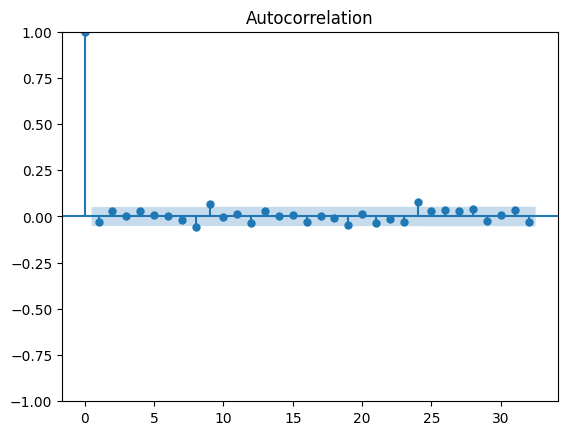

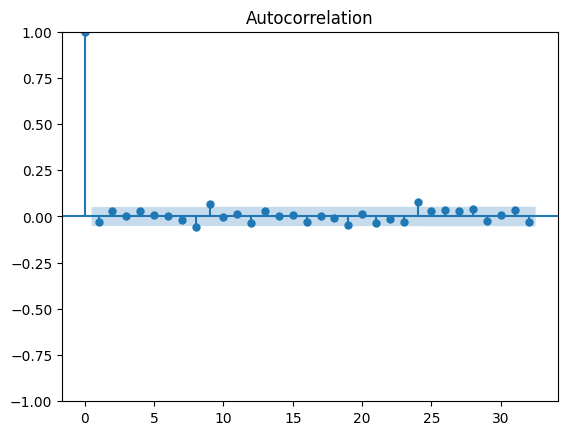

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_data['lreturn_btc'])

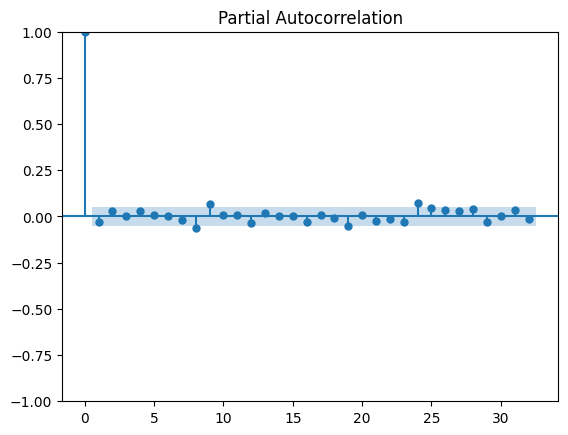

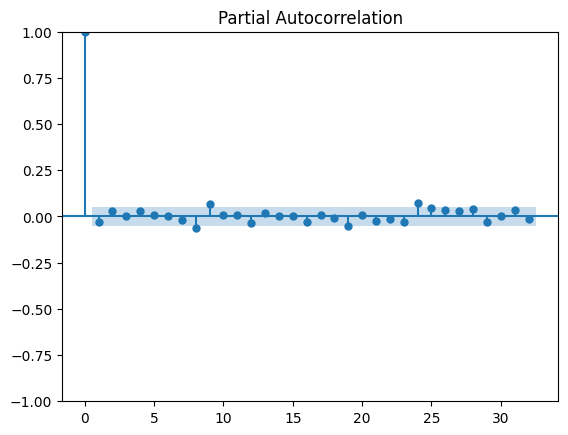

In [17]:
plot_pacf(bitcoin_data['lreturn_btc'])

In [18]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(
    bitcoin_data['lreturn_btc'],
    seasonal=False,  # Set to True if you suspect seasonality
    trace=True,      # Print model summary
    error_action='ignore',  # Ignore errors
    suppress_warnings=True, # Suppress warnings
    stepwise=True     # Use stepwise search to reduce computation time
)

print("Selected ARIMA Model:", arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5814.788, Time=14.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5819.447, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5818.836, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5818.750, Time=1.70 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5817.841, Time=3.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5818.394, Time=0.28 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 19.865 seconds
Selected ARIMA Model:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1449
Model:                        SARIMAX   Log Likelihood                2910.724
Date:                Fri, 27 Dec 2024   AIC                          -5819.447
Time:                        21:18:34   BIC                          -5814.169
Sample:                             0   HQIC               

In [19]:
from pmdarima.arima import auto_arima

sarima_model = auto_arima(
    bitcoin_data['lreturn_btc'],
    seasonal=True,
    m = 7,# Set to True if you suspect seasonality
    trace=True,      # Print model summary
    error_action='ignore',  # Ignore errors
    suppress_warnings=True, # Suppress warnings
    stepwise=True     # Use stepwise search to reduce computation time
)

print("Selected SARIMA Model:", sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-5810.587, Time=41.62 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-5818.394, Time=0.28 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-5816.364, Time=17.31 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-5816.271, Time=7.01 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-5819.447, Time=0.12 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-5816.819, Time=2.08 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-5816.815, Time=2.67 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-5814.859, Time=10.38 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=-5817.840, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-5817.757, Time=3.21 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=-5816.835, Time=7.25 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7]          
Total fit time: 92.208 seconds
Selected SARIMA Model:                                SARIMAX Results                                
Dep. Variable:                      y

According to the auto arima it is saying that it is already a white noise, lets check if there is any chance of presence of conditional heteroscedasticity.

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
result = acorr_ljungbox(bitcoin_data['lreturn_btc'], lags=10, return_df=True) 

print(result)

      lb_stat  lb_pvalue
1    1.441369   0.229918
2    2.791470   0.247651
3    2.804594   0.422744
4    4.275364   0.370020
5    4.378734   0.496271
6    4.394306   0.623477
7    4.815667   0.682446
8    9.736385   0.284018
9   16.827901   0.051480
10  16.828781   0.078240


In [21]:
# Perform the Ljung-Box test
result = acorr_ljungbox(bitcoin_data['lreturn_btc'] ** 2, lags=10, return_df=True) 

print(result)

      lb_stat     lb_pvalue
1   15.610223  7.783264e-05
2   19.223488  6.693797e-05
3   23.541027  3.114430e-05
4   36.453303  2.334369e-07
5   44.669013  1.693962e-08
6   53.099440  1.120416e-09
7   64.569304  1.835394e-11
8   69.077149  7.500428e-12
9   74.131569  2.344801e-12
10  74.305650  6.493506e-12


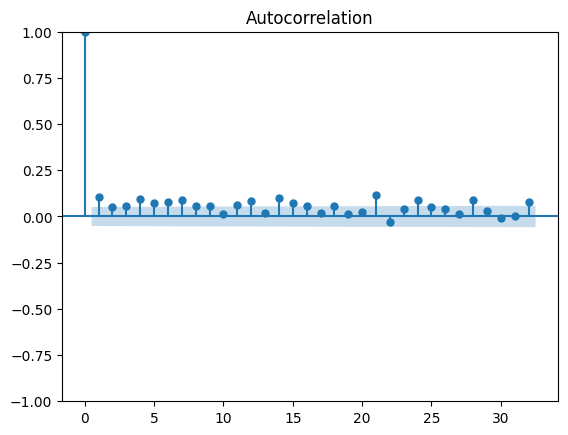

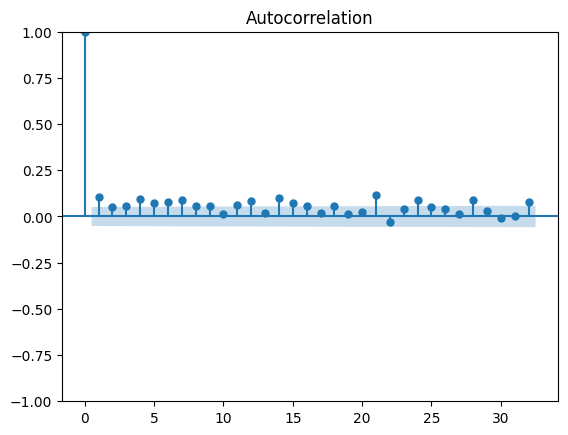

In [22]:
plot_acf(bitcoin_data['lreturn_btc'] ** 2)

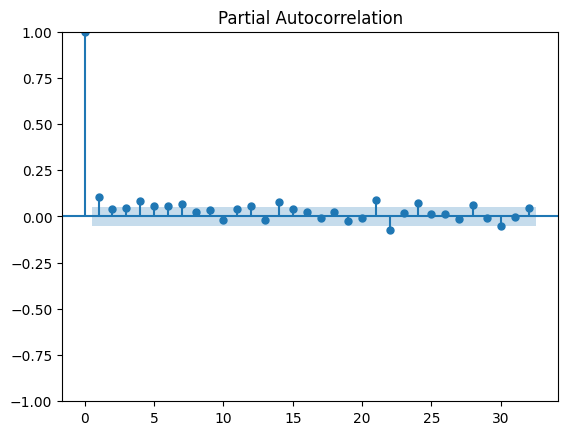

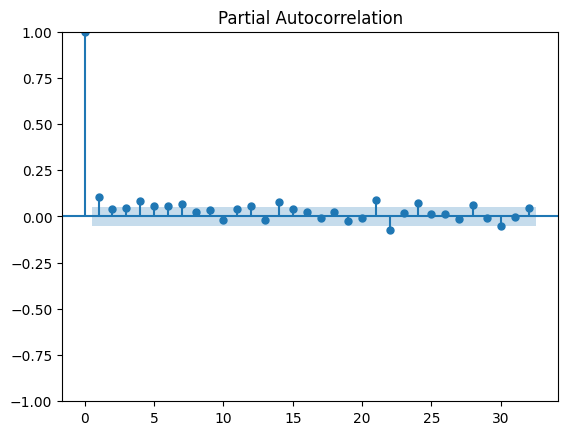

In [23]:
plot_pacf(bitcoin_data['lreturn_btc']**2)

From the acf and the pacf graphs obtained here we see that there is clearly a conditional heteroscedasticity.

In [24]:
from arch import arch_model

returns = bitcoin_data['lreturn_btc']

arch_4 = arch_model(returns,q = 4,
                      mean='constant', vol='ARCH', dist='normal')

# Fit the model
result = arch_4.fit(update_freq=4)

# Print model results
print(result.summary())

Iteration:      4,   Func. Count:     29,   Neg. LLF: -1916.6395068564843
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2929.0637986637144
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:            lreturn_btc   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2929.06
Distribution:                  Normal   AIC:                          -5852.13
Method:            Maximum Likelihood   BIC:                          -5836.29
                                        No. Observations:                 1449
Date:                Fri, Dec 27 2024   Df Residuals:                     1448
Time:                        21:20:08   Df Model:                            1
      

C:\Users\sahak\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




### Model Diagnostic:
1. First we check the standardised residuals to be independent normal
2. We may use histograms and Llunj-Box test to validate the same.

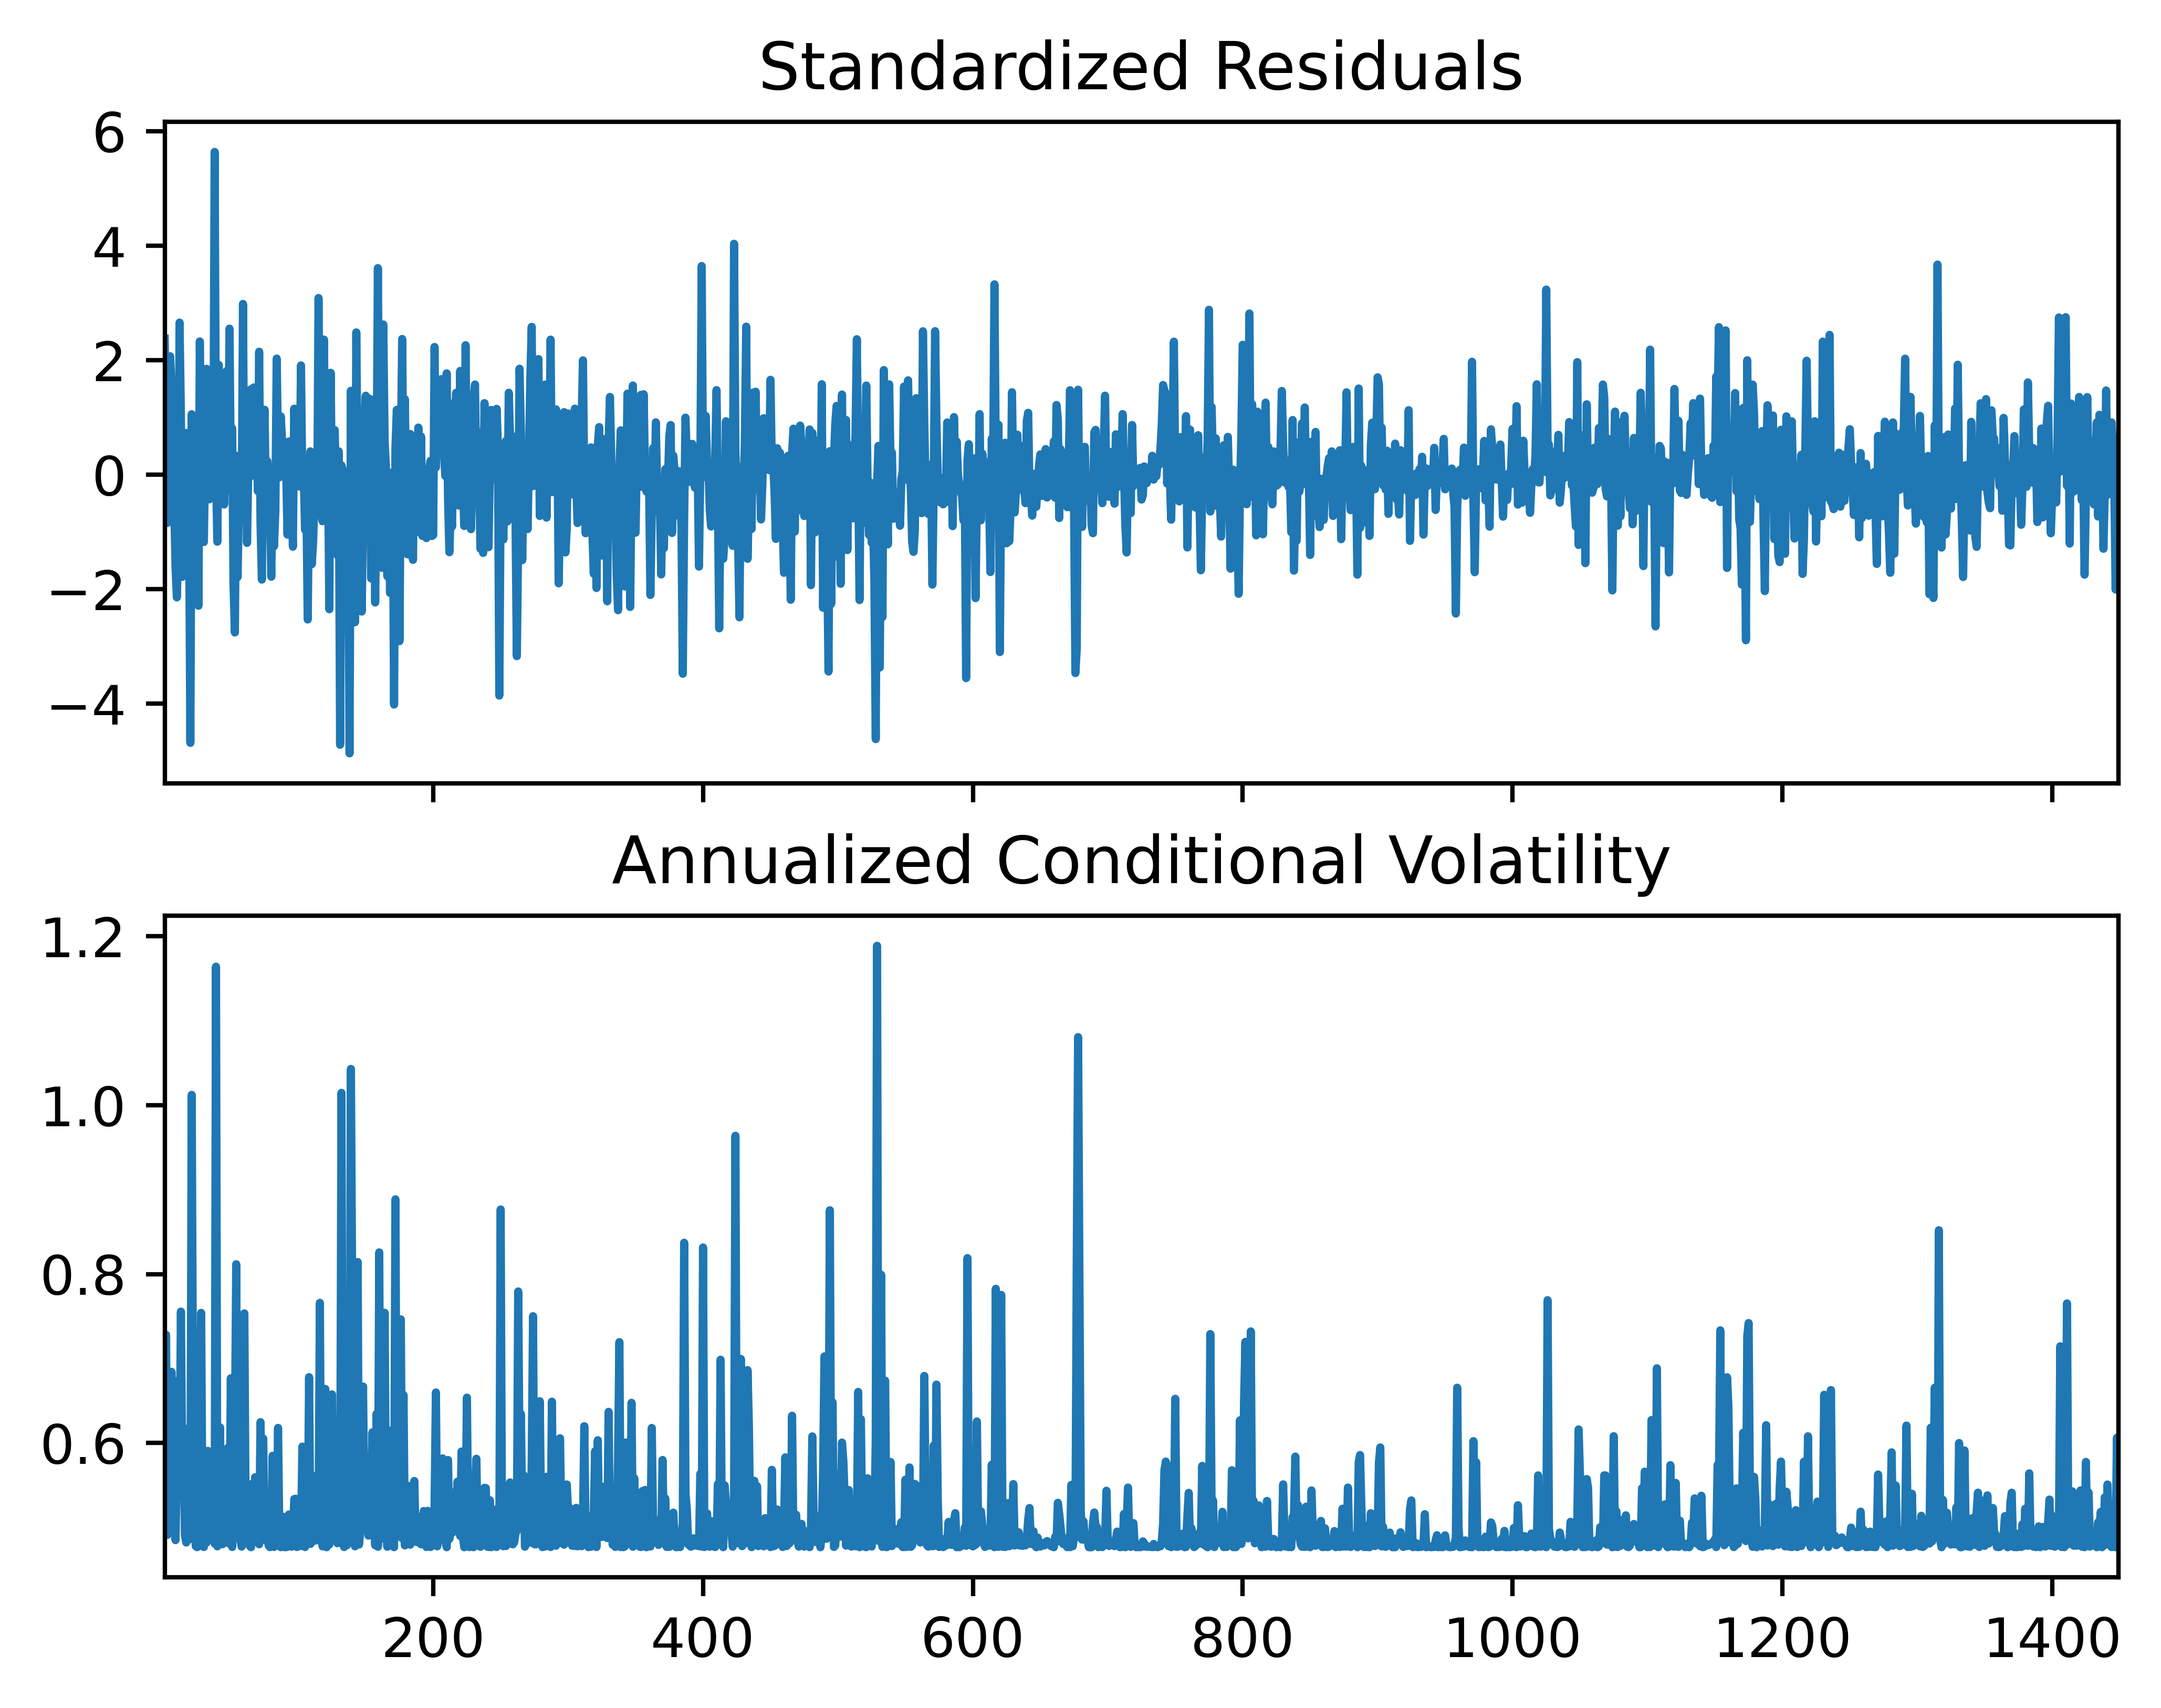

In [25]:
# Plot fitted results with high resolution
fig = result.plot(annualize="D")
fig.set_dpi(750)  # Set the DPI for the entire figure

# Show the plot
plt.show()

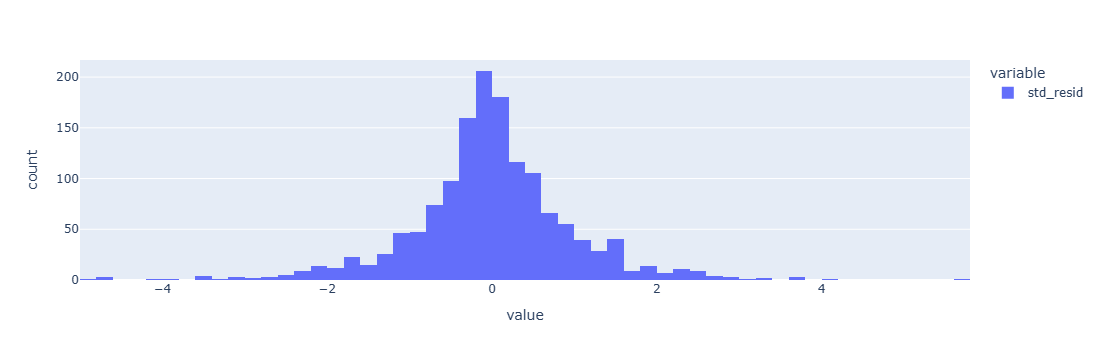

In [26]:
px.histogram(result.std_resid)

In [27]:
print(acorr_ljungbox(result.std_resid, lags=10, return_df=True))

      lb_stat  lb_pvalue
1    0.183155   0.668676
2    1.293108   0.523848
3    1.569241   0.666384
4    2.786548   0.594157
5    3.021387   0.696688
6    3.068050   0.800259
7    3.262871   0.859667
8    7.358289   0.498515
9   14.531654   0.104630
10  14.708170   0.143069


In [28]:
print(acorr_ljungbox(result.std_resid ** 2, lags=10, return_df=True))

      lb_stat     lb_pvalue
1    0.215210  6.427145e-01
2    2.747625  2.531400e-01
3    5.260136  1.537101e-01
4   17.241201  1.735093e-03
5   21.574488  6.306424e-04
6   27.898919  9.817178e-05
7   40.259134  1.122893e-06
8   43.181424  8.119548e-07
9   47.065860  3.815339e-07
10  47.112179  9.009253e-07


In [29]:
fig = px.line(y = result.conditional_volatility, x=bitcoin_data.Date,title="Volatility")
fig.add_trace(
    px.line(y=returns, x=bitcoin_data.Date).data[0]
)

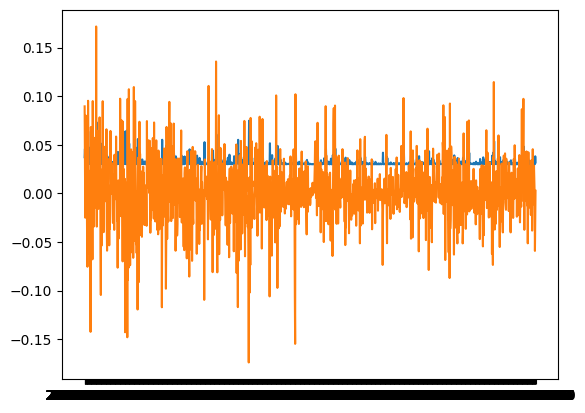

In [31]:
plt.plot(bitcoin_data.Date, result.conditional_volatility)
plt.plot(bitcoin_data.Date, bitcoin_data.lreturn_btc)

### Using GARCH

In [38]:
model_variance = arch_model(
    returns, 
    vol='Garch', 
    p=1, q=1, 
    x=None,  # No exogenous variable in mean
    power=2.0,
    # vol_options={'exog': data[['exog_variable']]}  # Exogenous variable in variance equation
)
result_variance = model_variance.fit(disp="off")
print("\nGARCH with Exogenous Variables in the Variance Equation:")
print(result_variance.summary())


GARCH with Exogenous Variables in the Variance Equation:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            lreturn_btc   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2978.98
Distribution:                  Normal   AIC:                          -5943.96
Method:            Maximum Likelihood   BIC:                          -5907.01
                                        No. Observations:                 1449
Date:                Fri, Dec 27 2024   Df Residuals:                     1448
Time:                        21:44:46   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------

C:\Users\sahak\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




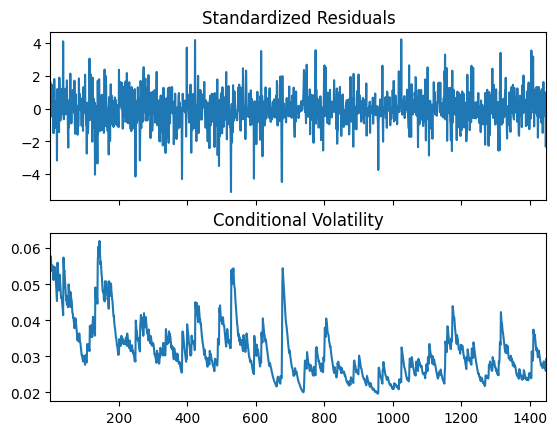

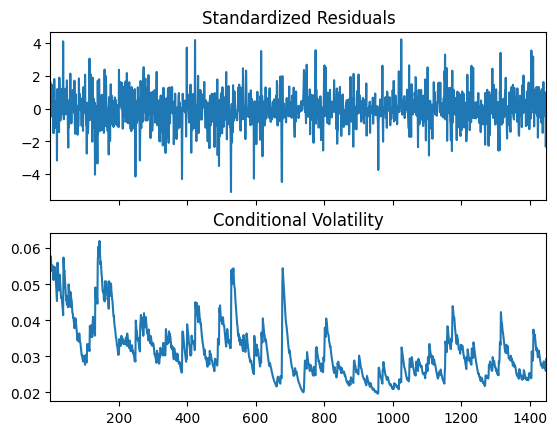

In [33]:
result_variance.plot()

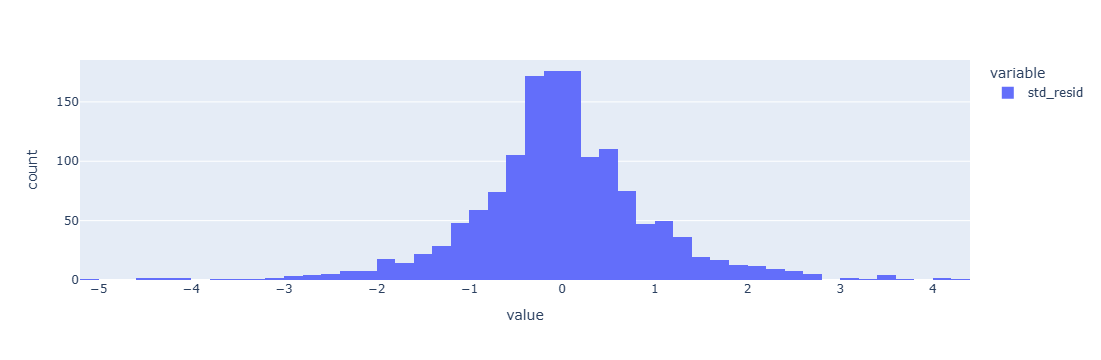

In [34]:
px.histogram(result_variance.std_resid)

In [36]:
print(acorr_ljungbox(result_variance.std_resid, lags=10, return_df=True))

      lb_stat  lb_pvalue
1    0.296734   0.585937
2    1.587066   0.452244
3    2.104816   0.550939
4    2.260120   0.688039
5    2.389143   0.793090
6    2.439601   0.875165
7    2.476252   0.928875
8    6.182031   0.626850
9   13.252163   0.151524
10  13.370815   0.203672


In [37]:
print(acorr_ljungbox(result_variance.std_resid ** 2, lags=10, return_df=True))

     lb_stat  lb_pvalue
1   3.918224   0.047765
2   4.425303   0.109410
3   5.954283   0.113856
4   6.327972   0.175957
5   6.342899   0.274268
6   6.427675   0.377023
7   6.837129   0.446033
8   7.102092   0.525659
9   7.737166   0.560835
10  9.487090   0.486583
